# 學習歷程

微分方程零基礎的我完全無法領受它的美，這讓過去曾短暫以進入QUANT領高薪作為職涯目標的我透過這門課認清了現實，果然財務工程還是適合那些擅長念數學的聰明人。我竭盡所能地找了大量的資料，對作業如何完成有了一定的構想，無奈程式能力不足，在寫genbrownpath時陷入了不管怎麼改都會出現不同種類error的處境，我會說明已經做好的部分、卡住的部分與未完成的部分若有機會突破原本的瓶頸會打算怎麼做。

# 一、找出Hull-White Model Short Rate

首先參考Goutham寫的這篇(http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html) 就可以在輸入了履約價格、無風險利率、到期日、波動率、hull-white model中的a參數、forward rate、當期股票價格後，成功得到hull-white model的利率期限結構。

In [1]:
pip install QuantLib-Python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

K = int(input())                #輸入履約價格
r = float(input())              #輸入無風險利率
mat = float(input())            #輸入到期日
sigma = float(input())          #輸入波動率
a = float(input())              #輸入參數a
forward_rate = float(input())   #輸入forward rate
S0 = float(input())             #輸入股票當期價格
timestep = int(mat * 360)
day_count = ql.Thirty360()
todays_date = ql.Date(9,5,2020)
ql.Settings.instance().evaluationDate = todays_date


80
0.05
0.5
0.1
0.1
0.05
100


In [3]:
spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, mat, timestep, rng, False)

In [4]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

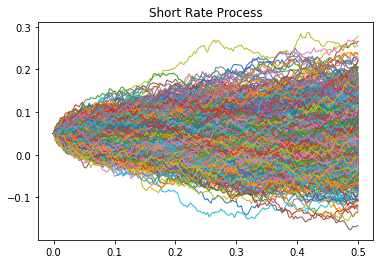

In [5]:
num_paths = 1000
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.title("Short Rate Process")
    plt.plot(time, paths[i, :], lw=1, alpha=1)
plt.show()

# 二、利用Geometric Brownian Motion預測股價動向

我在這裡除了程式寫不出來外就數學理論上也陷入了兩難，上網搜尋到了(https://quant.stackexchange.com/questions/18289/black-scholes-under-stochastic-interest-rates) 這裡的解答提到Hull-White Model股價會有一個隨機方程(SDE)的解:dS = S[rdt+σ(ρdWt1+sqrt(1-ρ^2)dWt2]，r跟S有t的註腳，Wt1與Wt2屬於獨立的布朗運動。照理來說應該要用這個解的Brownian Motion代入Short Rate繼續寫模型，但同時卻也可以用上方利率期限結構的結果把Geometric Brownian Motion中的mu取代後照著老師講義上gbm來跑的形式。我不知道兩者哪個才是對的。我使用的是替代掉mu的方式。
這裡程式上的問題出在arr，too many indices in a array、float object is not subscriptable(在arr外套上float時)、operands could not be broadcast together with shapes的error我都碰過，試圖上網找解決方式卻往往製造新的問題，是以心力俱疲。

In [6]:
dt = 0.01                      # define step size
sigma = 0.5
T = timestep
import math
result = []
n = round(T/dt)
W = np.random.standard_normal(size = n)
for k in range(n):
    X = ((arr[k,:] - 0.5 * sigma ** 2) * time[k] + sigma * W)
    S = S0 * math.exp(X)
    result.append(S) 
    W = np.cumsum(W)*np.sqrt(dt)

plt.plot(time, S, lw=0.8, alpha=0.6)
plt.title("Stock Price Simulation")
plt.show()


NameError: name 'arr' is not defined

# 三、折現回t = 0再算出選擇權價格

這裡預計將含有geometric brown motion股價結果的陣列，寫個迴圈記數，使得可以全部折現回第一期，再將結果輸入第四次作業寫的Black-Scholes選擇權定價模型，最終得到call和put的價格。